### 1. Import Libraries 

In [1]:
#Import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 

import os
import warnings

In [2]:
#Configure API key 
quandl.ApiConfig.api_key = 'GZE4tvwARREc4Zr7dF_G'

### 2. Import Data

In [5]:
#Import data for 'Solar Pow Capacity - Poland'

data = quandl.get('BP/SOLAR_CAP_POL')

In [6]:
data.head()

,Value
Date,
1997-12-31,0.0
1998-12-31,0.0
1999-12-31,0.0
2000-12-31,0.0
2001-12-31,0.0


In [7]:
data.shape

(25, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

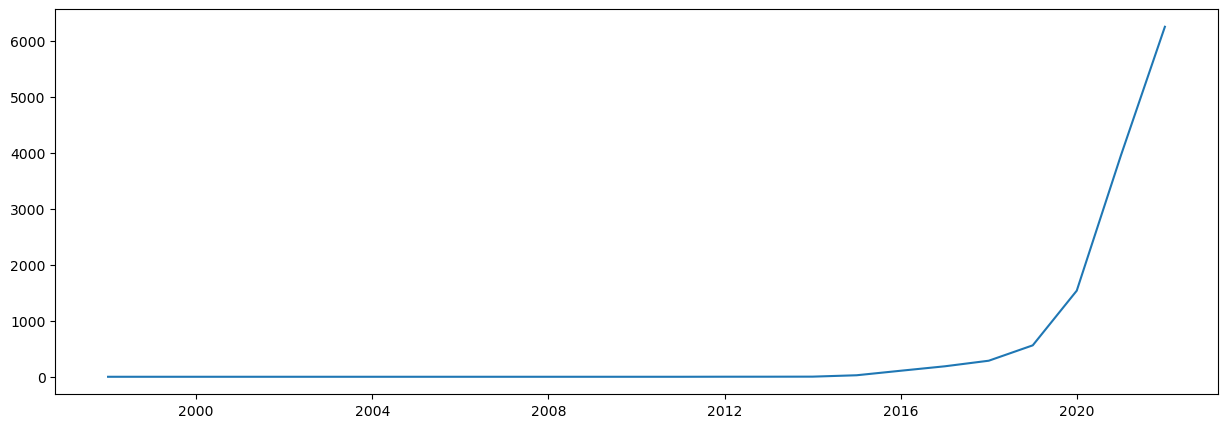

In [11]:
# Plot the data
plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

In [12]:
#Change index to use 'Date' column as a filter
data_2 = data.reset_index()

In [13]:
data_2.head()

,Date,Value
0,1997-12-31,0.0
1,1998-12-31,0.0
2,1999-12-31,0.0
3,2000-12-31,0.0
4,2001-12-31,0.0


### 3. Make a subset of your data set if necessary. 

In [15]:
#Create a subset based on 'Date'
data_sub = data_2.loc[(data_2['Date'] >= '2012-01-01') & (data_2['Date'] < '2021-12-31')]

This subset was chosen because it seems that this is when Poland was able to measure the solar power capacity. 

In [16]:
data_sub.head()

,Date,Value
15,2012-12-31,1.300
16,2013-12-31,2.393
17,2014-12-31,27.150
18,2015-12-31,107.777
19,2016-12-31,187.247


In [17]:
data_sub.shape

(9, 2)

In [18]:
#Index by 'Date'

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

/var/folders/2j/4cmd6qcd3j16bhj176m4p8vw0000gn/T/ipykernel_79091/184405877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['datetime'] = pd.to_datetime(data_sub['Date'])


,Value
datetime,
2012-12-31,1.300
2013-12-31,2.393
2014-12-31,27.150
2015-12-31,107.777
2016-12-31,187.247


### 4. Create a line chart of your data.

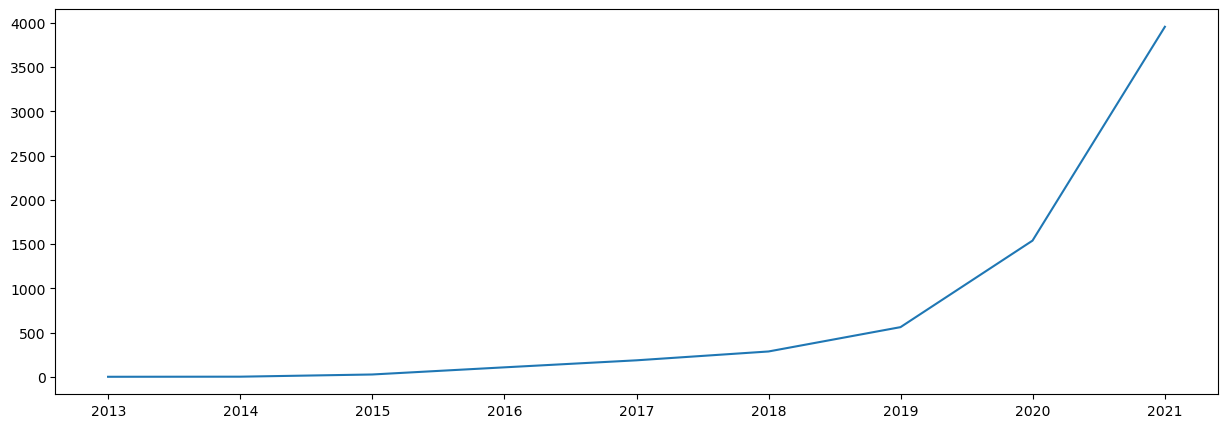

In [20]:
#Plot new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [21]:
#Check for missing values
data_sub.isnull().sum() 

Value    0
dtype: int64

In [22]:
#Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

No null values or duplicates were found. 

### 5. Decompose the data’s components.

In [23]:
#Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [24]:
#Define a fixed size for all special charts.
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

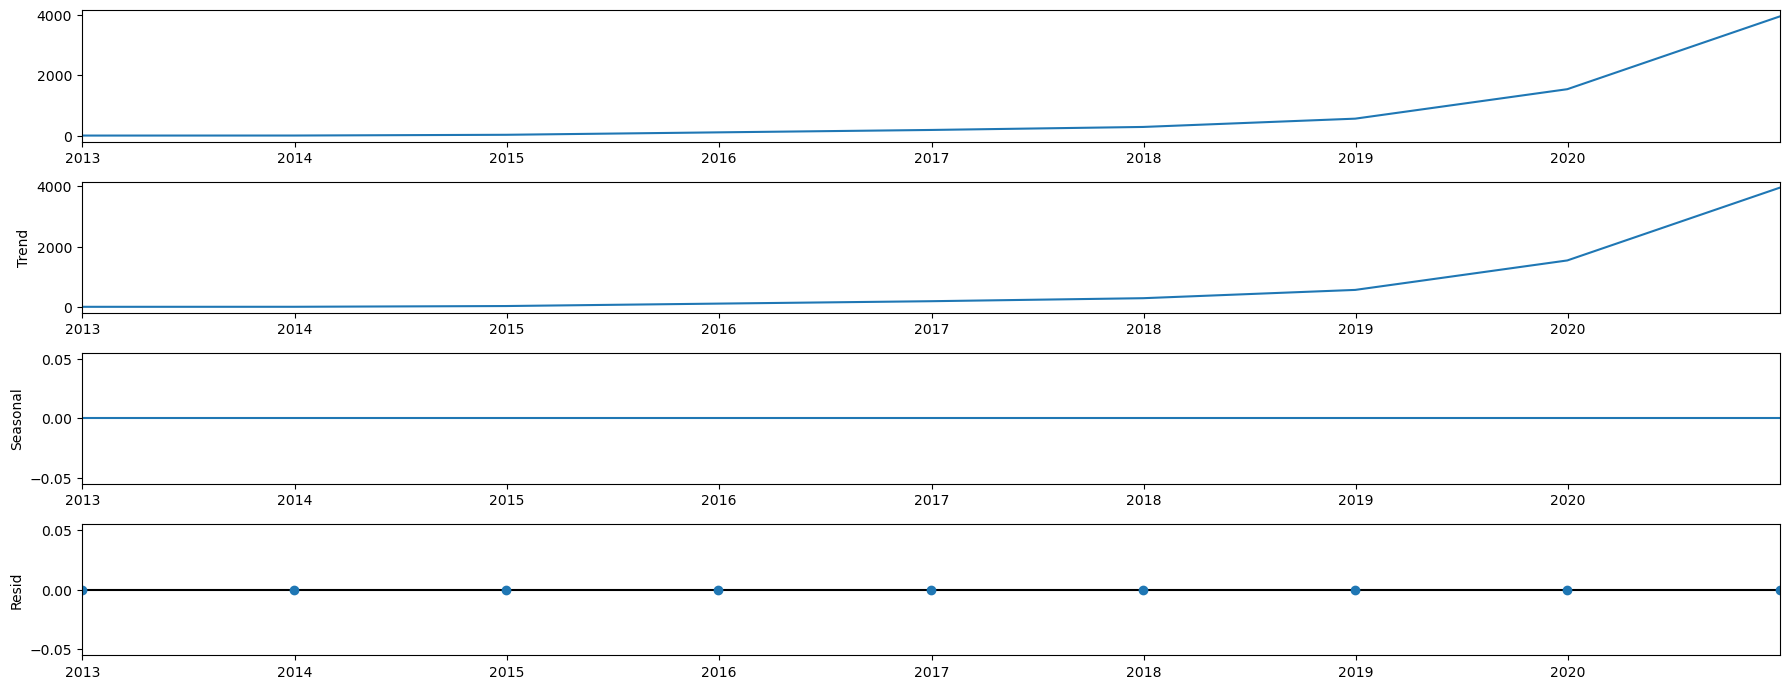

In [25]:
#Plot the components
decomposition.plot()
plt.show()

1. The first graph shows the solar power data. 
2. The second graph is the trend, showing an increasing trend. 
3. The third component is seasonality. There is no seasonity regarding solar power capacity. 
4. And finally we see in the last graph the residual (noise). No noise present. 

### 6. Conduct a Dickey-Fuller test to check for stationarity.

In [26]:
#Perform the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): 
  
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 4.108729
p-value                        1.000000
Number of Lags Used            2.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


The p-value is considerably higher than 0.05. The test stastistic is much larger than the critical value, so we can not reject the null hypothesis. There is a unit root in the data, and the data is non-stationary.

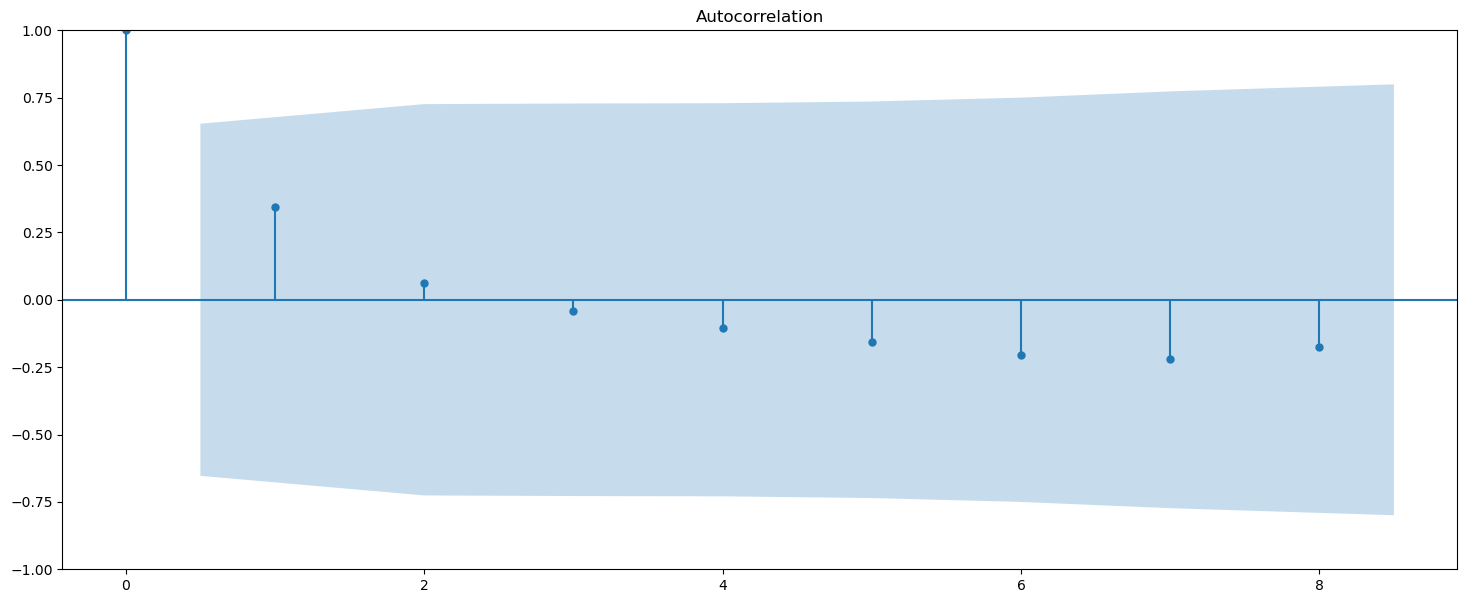

In [27]:
#Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

### 7. If your data isn’t stationary, conduct a round of differencing on it and repeat step 6.

In [28]:
#Change the observation to t-1
data_diff = data_sub - data_sub.shift(1)

In [29]:
#Remove missing values that came about as a result of the differencing.
data_diff.dropna(inplace = True) 

In [30]:
data_diff.head()

,Value
datetime,
2013-12-31,1.093
2014-12-31,24.757
2015-12-31,80.627
2016-12-31,79.470
2017-12-31,99.844


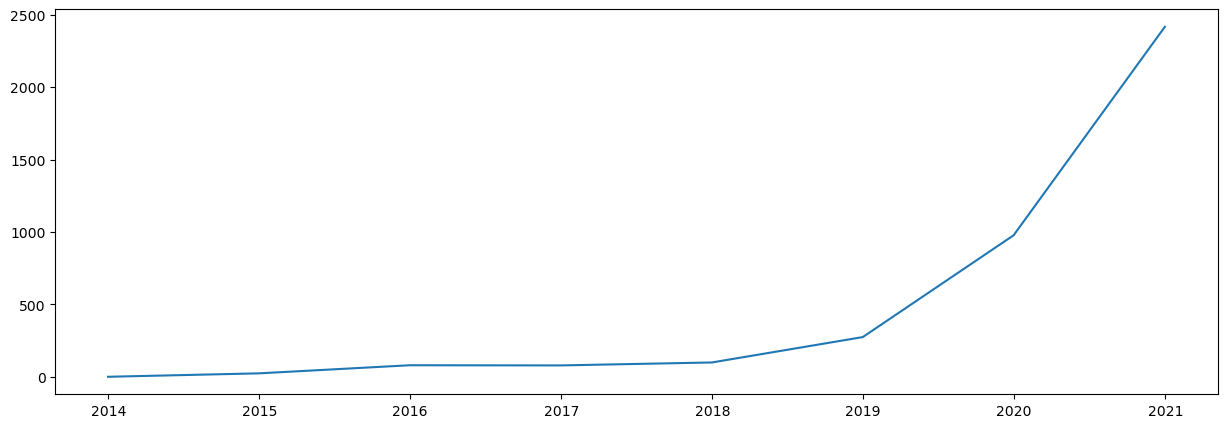

In [31]:
#Observe how differencing changed the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [32]:
#Perform new Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 0.987056
p-value                        0.994127
Number of Lags Used            2.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


The test stastistic is still larger than the critical value, so we can not reject the null hypothesis. There is a unit root in the data, and the data is non-stationary.

### 8. If your data still isn’t stationary, perform another round of differencing and repeat step 6.

In [33]:
#Change the observation to t-1
data_diff_2 = data_diff - data_diff.shift(1)

In [34]:
#Remove missing values that came about as a result of the differencing.
data_diff_2.dropna(inplace = True) 

In [35]:
data_diff_2.head()

,Value
datetime,
2014-12-31,23.664
2015-12-31,55.870
2016-12-31,-1.157
2017-12-31,20.374
2018-12-31,175.041


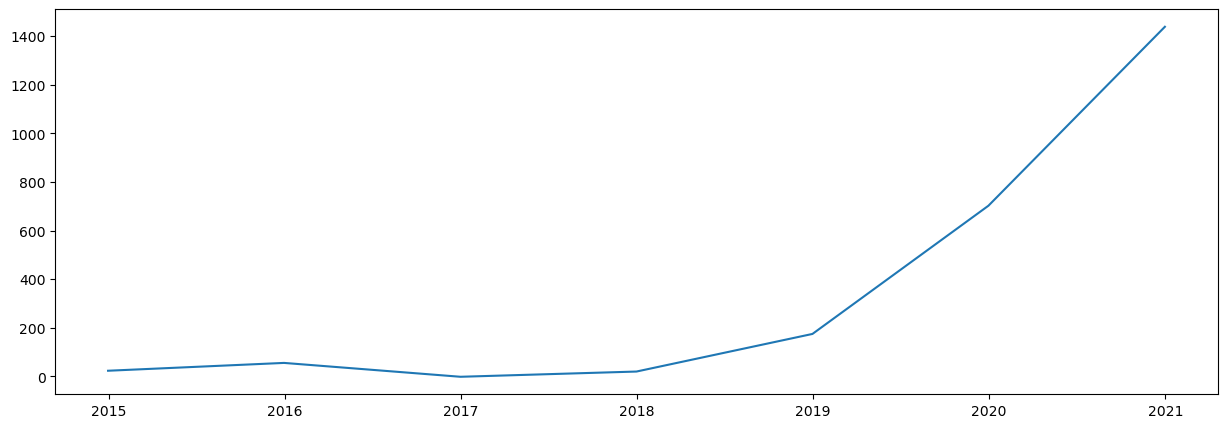

In [36]:
#Observe how differencing changed the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [37]:
#Perform new Dickey-Fuller test
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -0.707454
p-value                        0.844809
Number of Lags Used            1.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


Though the results are slightly better, the test stastistic is still larger than the critical value, so we can not reject the null hypothesis. There is a unit root in the data, and the data is non-stationary.

### 9. Check your data’s autocorrelations.

#### I chose to show the autocorrelations for both data differencings

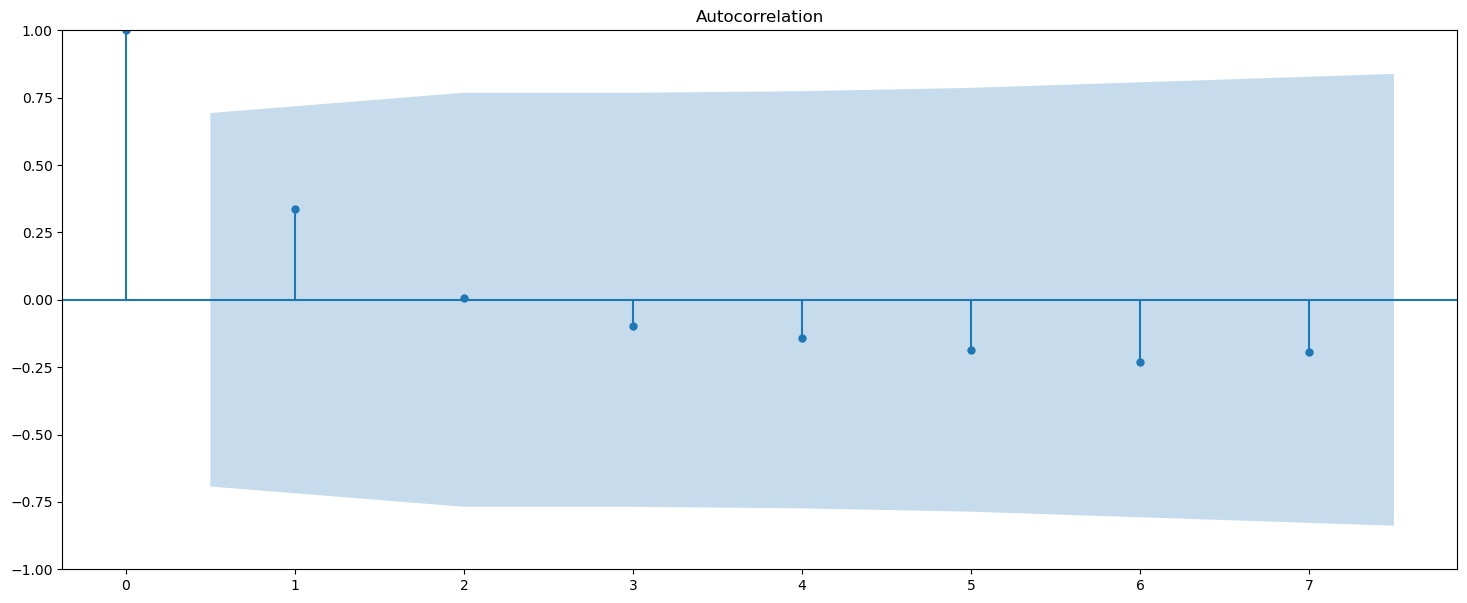

In [38]:
plot_acf(data_diff)
plt.show()

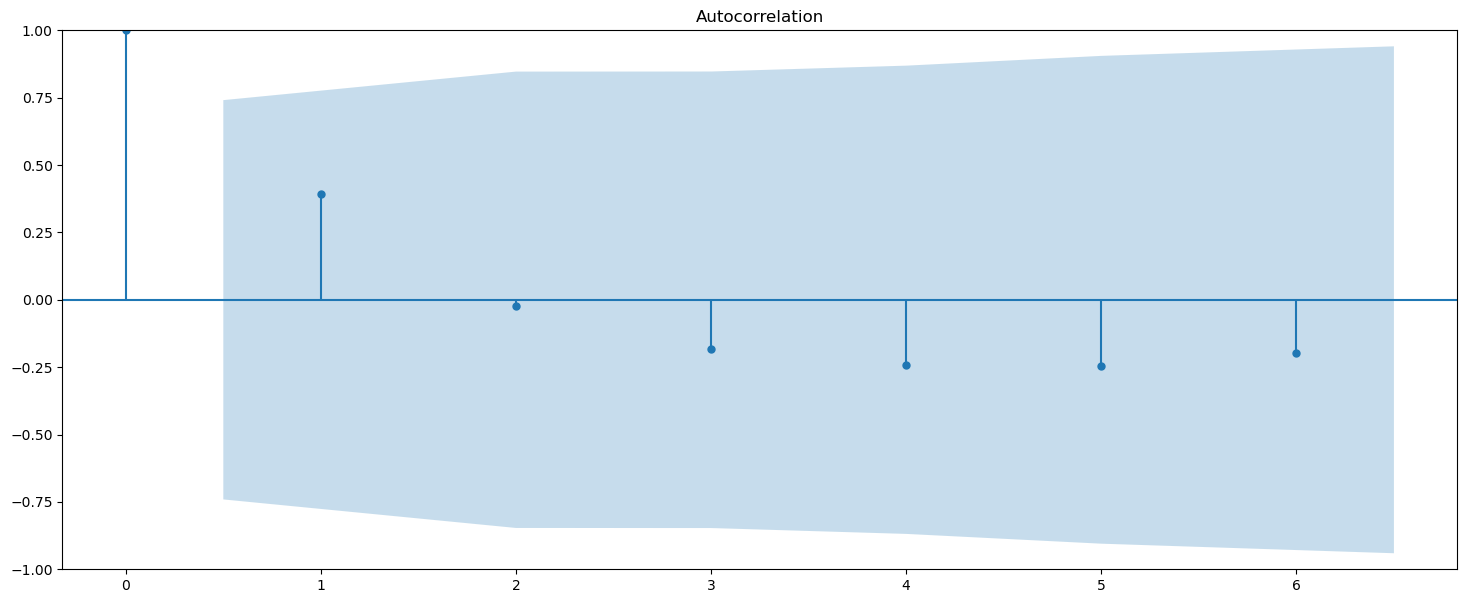

In [39]:
plot_acf(data_diff_2)
plt.show()